In [1]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score,recall_score, f1_score,roc_auc_score,roc_curve
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
%matplotlib inline 

Using TensorFlow backend.


In [2]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.99):
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True

In [3]:
def create_training_data():
    pospath =r'E:\surface-crack-detection\crack'
    negpath =r'E:\surface-crack-detection\non_crack'
    for img in tqdm(os.listdir(pospath),desc="Reading Positive Images",ncols=100):
        img_array = cv2.imread(os.path.join(pospath,img) ,0) 
        new_array = cv2.resize(img_array,(100,75)) 
        training_data.append([new_array, 1]) 
    for img in tqdm(os.listdir(negpath),desc="Reading Negative Images",ncols=100):
        img_array = cv2.imread(os.path.join(negpath,img) ,0)
        new_array = cv2.resize(img_array,(100,75)) 
        training_data.append([new_array, 0]) 

In [4]:
def creating_model():
    model = Sequential()

    model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',input_shape=X.shape[1:]))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
    model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Dense(30, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
     
    return model

In [5]:
training_data = []      
create_training_data()

Reading Negative Images: 100%|███████████████████████████████| 20000/20000 [00:22<00:00, 893.65it/s]


In [6]:
random.shuffle(training_data)
X=[]
y=[]
for features,label in training_data:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1,100,75, 1)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20,random_state=1234)

In [7]:
model= creating_model()
callbacks = myCallback()

In [8]:
model.fit(x=X,y=y,
          epochs=15,
          callbacks=[callbacks],
          validation_split=0.1)

Train on 36000 samples, validate on 4000 samples
Epoch 1/15
36000/36000 [==============================] - 632s 18ms/step - loss: 0.0848 - accuracy: 0.9762 - val_loss: 0.0181 - val_accuracy: 0.9952
Epoch 2/15
36000/36000 [==============================] - 603s 17ms/step - loss: 0.0516 - accuracy: 0.9861 - val_loss: 0.0168 - val_accuracy: 0.9950
Epoch 3/15
36000/36000 [==============================] - 615s 17ms/step - loss: 0.0469 - accuracy: 0.9872 - val_loss: 0.0256 - val_accuracy: 0.9948
Epoch 4/15
36000/36000 [==============================] - 620s 17ms/step - loss: 0.0510 - accuracy: 0.9855 - val_loss: 0.0154 - val_accuracy: 0.9958
Epoch 5/15
36000/36000 [==============================] - 622s 17ms/step - loss: 0.0377 - accuracy: 0.9891 - val_loss: 0.0212 - val_accuracy: 0.9933
Epoch 6/15
36000/36000 [==============================] - 625s 17ms/step - loss: 0.0357 - accuracy: 0.9902 - val_loss: 0.1476 - val_accuracy: 0.9718

Reached 99% accuracy so cancelling training!


In [9]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 75, 32)       320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 37, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 37, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 37, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 37, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 18, 64)       

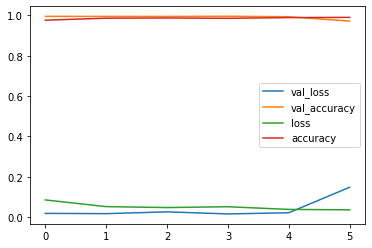

In [10]:
prediction=pd.DataFrame(model.history.history)
prediction.plot()

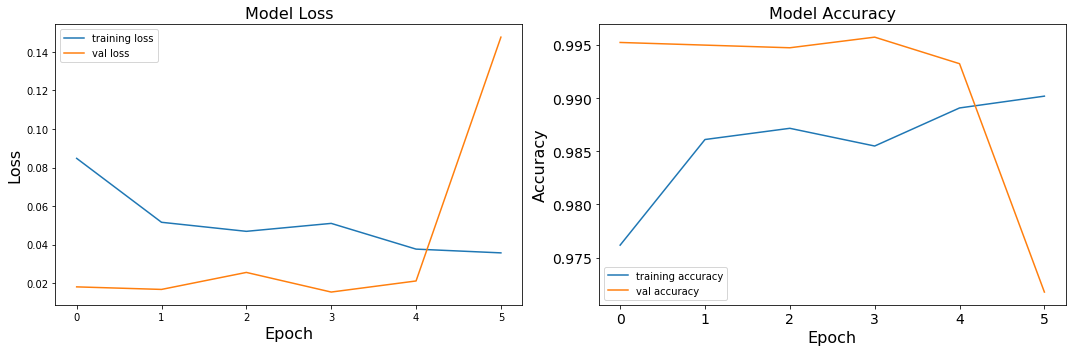

In [11]:
fig, (ax1,ax2)= plt.subplots(nrows=1, ncols=2,figsize=(15,5))

ax1.plot(prediction['loss'],label='training loss')
ax1.plot(prediction['val_loss'],label='val loss')
ax1.set_title('Model Loss',{'size':16})
ax1.set_xlabel('Epoch',{'size':16})
ax1.set_ylabel('Loss',{'size':16})
ax1.legend(loc='best')

ax2.plot(prediction['accuracy'],label='training accuracy')
ax2.plot(prediction['val_accuracy'],label='val accuracy')
ax2.set_title('Model Accuracy',{'size':16})
ax2.set_xlabel('Epoch',{'size':16})
ax2.set_ylabel('Accuracy',{'size':16})
ax2.legend(loc='best')
              
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.show()

In [12]:
y_score = model.predict_classes(X_test)

cm = confusion_matrix(y_test, y_score)
print('confusion_matrix\n', cm)

print('accuracy:{}'.format(accuracy_score(y_test, y_score)))
print('precision:{}'.format(precision_score(y_test, y_score)))
print('recall:{}'.format(recall_score(y_test, y_score)))
print('f1-score:{}'.format(f1_score(y_test, y_score)))

confusion_matrix
 [[4017    0]
 [ 212 3771]]
accuracy:0.9735
precision:1.0
recall:0.9467737886015566
f1-score:0.9726592726334795


Text(33.0, 0.5, 'True')

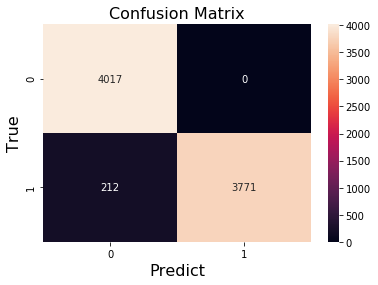

In [13]:
f,ax=plt.subplots()
sns.heatmap(cm,annot=True,ax=ax,fmt='.4g') 

ax.set_title('Confusion Matrix',fontsize=16)
ax.set_xlabel('Predict',fontsize=16)
ax.set_ylabel('True',fontsize=16) 

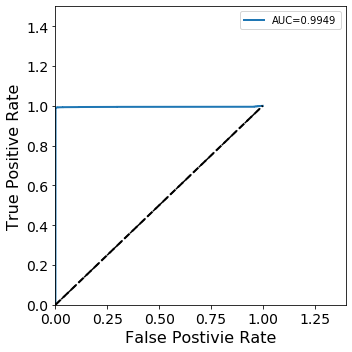

In [14]:
y_score_1 = model.predict(X_test)
fig, ax = plt.subplots(figsize=(5,5))

auc = roc_auc_score(y_test,y_score_1)

fpr, tpr, thresholds = roc_curve(y_test,y_score_1)   
ax.plot(fpr, tpr, linewidth = 2,label='AUC=%.4f' % auc)
ax.plot([0,1],[0,1], 'k--')


ax.set_xlim(0, 1.4)
ax.set_ylim(0, 1.50)
ax.set_xlabel('False Postivie Rate',{'size':16})
ax.set_ylabel('True Positive Rate',{'size':16})

ax.plot([0,1],[0,1], 'k--' ,lw=2)

plt.tick_params(labelsize=14)

plt.legend(loc="best")
plt.tight_layout()
plt.show() 